La empresa desea saber si tiene los recursos necesarios para soportar la demanda de los usuarios e
incrementar el numero de ticktes por día. En base a ello, diseñe y desarrolle un modelo y/o script que
permita realizar la simulación del proceso de pasar cuenca-aire con las siguientes especificaciones

- La empresa tiene 3 carriles de revisión vehicular
- Un solo carril es habilitado para carros de gran tonelaje, busetas, bus, camiones, solo el 15 % de vehiculos que llegan son de este tipo.
- Cada 3 minutos llega un nuevo vehiculo a revision.
- Se sigue el siguiente proceso:

1) Llega el vehiculo al centro, se estaciona (3-5 minutos), saca un turno (1-3 minutos) y pagan
la matricula (5 - 10 minutos).
2) Si esta vacio pasa directo a la revisión que tiene una media de 20 minutos con una
desviacion estandar de 10 minutos.
3) Solo el 60 % de vehiculos pasa sin ninguna notificación, el 40% salen realizan el arreglo (2
dias) y nuevamente realizan el proceso.
4) Despues de pasar la revisión, se les pega el sello (1 – 3 minutos) .
5) Finalmente, salen (5 – 10 minutos).
Generar un modelo de simulación por 30 dias y generar las siguientes graficas de resultados:
- Numero de vehiculos atendidos por dia, y por carril
- Porcentaje total de vehiculos aprobados y no aprobados en cuenca aire por dia.
- Tiempos del proceso de matriculación, por dia.


In [13]:
import simpy
import random
import math 
import numpy as np 


carril1_dia={}
carril2_dia={}
carrilP_dia={}

prov_dia={}
deneg_dia={}

tiempos_dia={}

tiempoTotalDia=0

tiempoRev = 3

tiempoEjecucion= 43200  # 30 dias
dia =1

num_c_livianos=2
num_c_pesados = 1

res = [2,1]
class EMOV(object):
    
    def __init__(self, environment, num_c_livianos, num_c_pesados):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinasL = simpy.Resource(environment, num_c_livianos)
        self.maquinasP = simpy.Resource(environment, num_c_pesados)
        


        
    def matricular_pesado(self, vehiculo):
        mu, sigma = 20, 10 # media y desvio estandar
        tiempo = abs(math.ceil(np.random.normal(mu, sigma, 1))) #media de 20 minutos con una desviacion estandar de 10 minutos.
        yield self.env.timeout(tiempo)

        print('El vehiculo vehiculo %s a tardado %s minutos en la revicion' % (vehiculo, tiempo))
        
        tiempoTotalDia =+ tiempo


    def matricular_liviano(self, vehiculo):
        mu, sigma = 20, 10 # media y desvio estandar
        tiempo = abs(math.ceil(np.random.normal(mu, sigma, 1))) #media de 20 minutos con una desviacion estandar de 10 minutos.
        yield self.env.timeout(tiempo)

        print('El vehiculo vehiculo %s a tardado %s minutos en la revicion' % (vehiculo, tiempo))
        
        tiempoTotalDia =+ tiempo



       

def generar_auto():
    num = random.randint(1,100)

    if num <= 15:
        num2 = random.randint(0,2)
        gt = ["Buseta", "Bus", "Camion"]
        return gt[num2]
    else:
        num2 = random.randint(0,2)
        tipos = ["Camioneta","Automóvil","Jeep"]
        return tipos[num2]



def llegada_vehiculo(env, nombre, emov):
    

    t=0
    print('Llega : %s a la hora %.2f.' % (nombre, env.now))
    t=random.randint(3,5)
    yield env.timeout(t)
    print(' %s Espero estacionado por: %s minutos (Hora Actual: %.2f.)' % (nombre, t, env.now))
    
    tiempoTotalDia =+ t

    t=random.randint(1,3)
    yield env.timeout(t)
    print(' %s Saco su turno en: %s minutos (Hora Actual: %.2f.)' % (nombre, t, env.now))
    
    tiempoTotalDia =+ t

    
    t=random.randint(5,10)
    yield env.timeout(t)
    print(' %s Pago su matricula, tardandose: %s minutos (Hora Actual: %.2f.)' % (nombre, t, env.now))
    
    tiempoTotalDia =+ t

    numActual=0


    if 'Buseta' in nombre or 'Bus' in nombre or 'Camion' in nombre: 

        with emov.maquinasP.request() as maquinaP:
            yield maquinaP
            print('Revisandose: %s a la hora %.2f en carril para vehiculos de Gran Tonelaje.' % (nombre, env.now))
            
            yield env.process(emov.matricular_pesado(nombre))
            
                    
    else: 
        
        with emov.maquinasL.request() as maquinaL:
            
            yield maquinaL
            numActual=res.pop()
            print('Revisandose: %s a la hora %.2f en uno de  los carriles para vehiculos pequeños.' % (nombre, env.now))
            yield env.process(emov.matricular_liviano(nombre))
            res.append(numActual)

    num = random.randint(1,100)
    if num <= 40:
        
        print('!!!!! El Carro: %s No cumple con los requisitos!!!!! (Dia: %.2f )' % (nombre, math.ceil(env.now/1440)))

        k=math.ceil(env.now/1440)


        if numActual == 0:  
            if k in carrilP_dia:
                carrilP_dia[k]=carrilP_dia[k]+1 # Aumento el numero de autos en el tiempo de salida
            else:
                carrilP_dia[k]=1
        elif numActual == 1:
            if k in carril1_dia:
                carril1_dia[k]=carril1_dia[k]+1 # Aumento el numero de autos en el tiempo de salida
            else:
                carril1_dia[k]=1
        elif numActual == 2: 
            if k in carril2_dia:
                carril2_dia[k]=carril2_dia[k]+1 # Aumento el numero de autos en el tiempo de salida
            else:
                carril2_dia[k]=1



        if k in deneg_dia:
            deneg_dia[k]=deneg_dia[k]+1 # Aumento el numero de autos en el tiempo de salida
        else:
            deneg_dia[k]=1


        if k in tiempos_dia:
            tiempos_dia[k]=tiempos_dia[k]+tiempoTotalDia
            tiempoTotalDia=0 # Aumento el numero de autos en el tiempo de salida
        else:
            tiempos_dia[k]=tiempoTotalDia
            tiempoTotalDia=0



        yield env.timeout(2880)
        print('-----------♣♣ El Carro: %s Ah vuelto!! ♠♠------------- (Dia: %.2f)' % (nombre, math.ceil(env.now/1440)))

        #
        volver(env,nombre,emov)
        
        
    else:
        print('El Carro: %s cumple con los requisitos ☻ (Hora %.2f)' % (nombre, env.now))
        t=random.randint(1,3)
        yield env.timeout(t)
        print('El Carro: %s recibe un sello en %x Minutos' % (nombre, t))
        
        tiempoTotalDia =+ t

        t=random.randint(1,3)
        yield env.timeout(t)
        print('El Carro: %s salio del establecimiento en %x Minutos (Dia: %.2f)' % (nombre, t, math.ceil(env.now/1440)))
        
        tiempoTotalDia =+ t

        k=math.ceil(env.now/1440)
        
        if numActual == 0:  
            if k in carrilP_dia:
                carrilP_dia[k]=carrilP_dia[k]+1 # Aumento el numero de autos en el tiempo de salida
            else:
                carrilP_dia[k]=1
        elif numActual == 1:
            if k in carril1_dia:
                carril1_dia[k]=carril1_dia[k]+1 # Aumento el numero de autos en el tiempo de salida
            else:
                carril1_dia[k]=1
        elif numActual == 2: 
            if k in carril2_dia:
                carril2_dia[k]=carril2_dia[k]+1 # Aumento el numero de autos en el tiempo de salida
            else:
                carril2_dia[k]=1



        if k in prov_dia:
            prov_dia[k]=prov_dia[k]+1 # Aumento el numero de autos en el tiempo de salida
        else:
            prov_dia[k]=1


        if k in tiempos_dia:
            tiempos_dia[k]=tiempos_dia[k]+tiempoTotalDia
            tiempoTotalDia=0 # Aumento el numero de autos en el tiempo de salida
        else:
            tiempos_dia[k]=tiempoTotalDia
            tiempoTotalDia=0





        
    

def volver(env,nombre,emov):
    env.process(llegada_vehiculo(env,nombre,emov))




def ejecutar_simulacion(env, num_c_livianos, num_c_pesados):
    emov=EMOV(env, num_c_livianos, num_c_pesados)
    global tiempoTotalDia
    
    i=0
    # Ejecutamos la simulacion
    while True:    
            
                       
        yield env.timeout(3)
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
                                                #Floro
        env.process(llegada_vehiculo(env,str(generar_auto())+'-%d'%(i),emov))










env=simpy.Environment()
env.process(ejecutar_simulacion(env, num_c_livianos, num_c_pesados))



env.run(until = tiempoEjecucion)

print(carril1_dia)
print(carril2_dia)
print(carrilP_dia)

print(prov_dia)
print(deneg_dia)

print(tiempos_dia)







Llega : Camioneta-1 a la hora 3.00.
Llega : Automóvil-2 a la hora 6.00.
 Camioneta-1 Espero estacionado por: 4 minutos (Hora Actual: 7.00.)
 Camioneta-1 Saco su turno en: 1 minutos (Hora Actual: 8.00.)
Llega : Jeep-3 a la hora 9.00.
 Automóvil-2 Espero estacionado por: 3 minutos (Hora Actual: 9.00.)
Llega : Camioneta-4 a la hora 12.00.
 Jeep-3 Espero estacionado por: 3 minutos (Hora Actual: 12.00.)
 Automóvil-2 Saco su turno en: 3 minutos (Hora Actual: 12.00.)
Llega : Camioneta-5 a la hora 15.00.
 Jeep-3 Saco su turno en: 3 minutos (Hora Actual: 15.00.)
 Camioneta-4 Espero estacionado por: 4 minutos (Hora Actual: 16.00.)
 Camioneta-4 Saco su turno en: 1 minutos (Hora Actual: 17.00.)
 Camioneta-1 Pago su matricula, tardandose: 10 minutos (Hora Actual: 18.00.)
Llega : Jeep-6 a la hora 18.00.
Revisandose: Camioneta-1 a la hora 18.00 en carril para vehiculos de Gran Tonelaje.
 Camioneta-5 Espero estacionado por: 5 minutos (Hora Actual: 20.00.)
 Automóvil-2 Pago su matricula, tardandose: 9 

{1: 71, 2: 65, 3: 71, 4: 68, 5: 67, 6: 65, 7: 68, 8: 66, 9: 73, 10: 69, 11: 68, 12: 60, 13: 74, 14: 65, 15: 78, 16: 72, 17: 72, 18: 73, 19: 68, 20: 66, 21: 68, 22: 70, 23: 65, 24: 71, 25: 64, 26: 64, 27: 69, 28: 69, 29: 69, 30: 72}
{1: 65, 2: 69, 3: 67, 4: 67, 5: 64, 6: 74, 7: 69, 8: 74, 9: 74, 10: 67, 11: 65, 12: 75, 13: 67, 14: 70, 15: 76, 16: 70, 17: 70, 18: 73, 19: 71, 20: 73, 21: 72, 22: 68, 23: 76, 24: 72, 25: 69, 26: 68, 27: 68, 28: 78, 29: 68, 30: 67}
{1: 72, 2: 80, 3: 71, 4: 72, 5: 73, 6: 70, 7: 73, 8: 72, 9: 67, 10: 66, 11: 68, 12: 68, 13: 69, 14: 76, 15: 70, 16: 64, 17: 70, 18: 76, 19: 70, 20: 71, 21: 73, 22: 74, 23: 65, 24: 67, 25: 68, 26: 72, 27: 68, 28: 71, 29: 61, 30: 72}


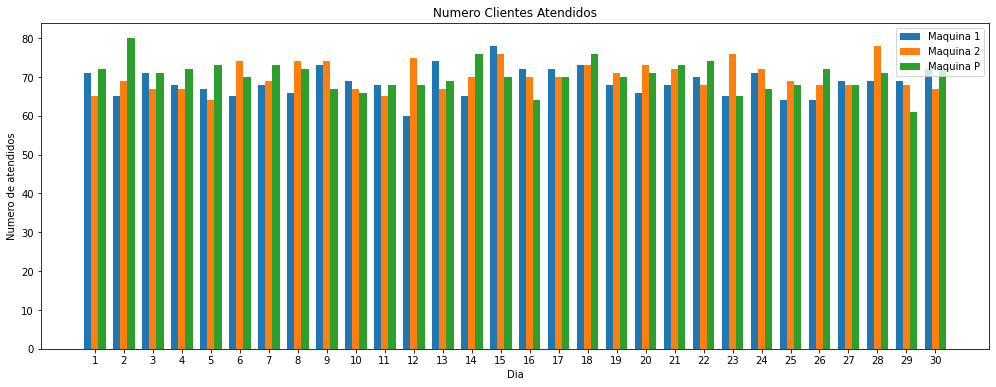

In [25]:
import matplotlib.pyplot as plt
#Numero de Vehiculos atendidos al dia, Por carril
print(carril1_dia)
print(carril2_dia)
print(carrilP_dia)

etiqueta = list(carril1_dia.keys())
valores1 = list(carril1_dia.values())
valores2 = list(carril2_dia.values())
valoresp = list(carrilP_dia.values())



numero_de_grupos = len(carril1_dia)
indice_barras = np.arange(numero_de_grupos)
ancho_barras =0.25
 
plt.figure(figsize=(17,6), )
plt.bar(indice_barras, valores1, width=ancho_barras, label='Maquina 1')
plt.bar(indice_barras + ancho_barras, valores2, width=ancho_barras, label='Maquina 2')
plt.bar(indice_barras + ancho_barras + ancho_barras, valoresp, width=ancho_barras, label='Maquina P')
plt.legend(loc='best')
## Se colocan los indicadores en el eje x
plt.xticks(indice_barras + ancho_barras, (etiqueta))
 
plt.ylabel('Numero de atendidos')
plt.xlabel('Dia')
plt.title('Numero Clientes Atendidos')
 
plt.show()

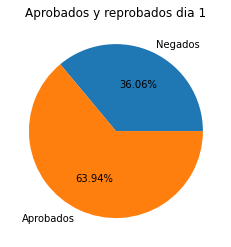

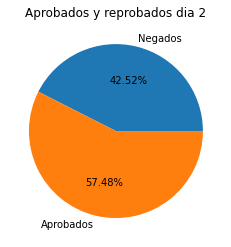

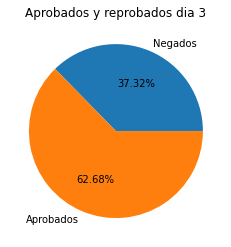

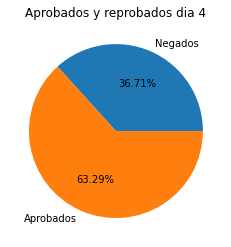

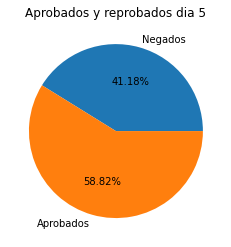

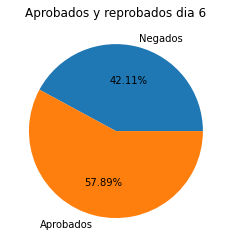

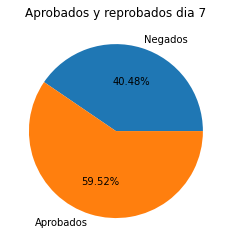

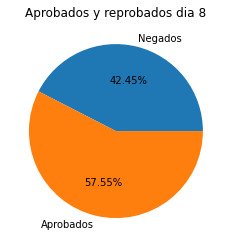

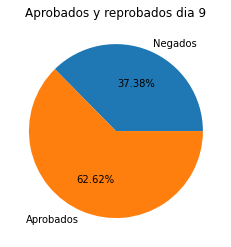

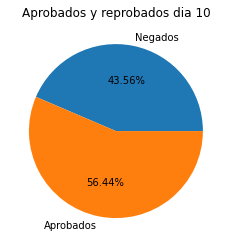

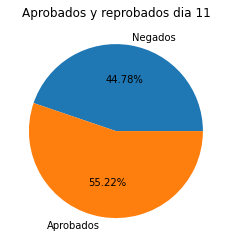

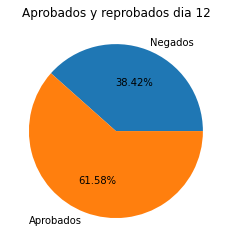

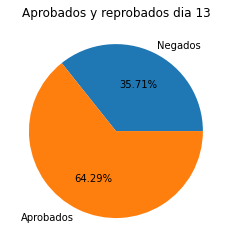

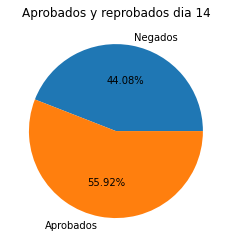

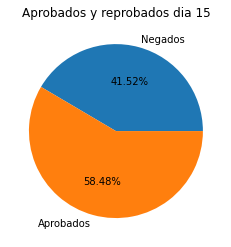

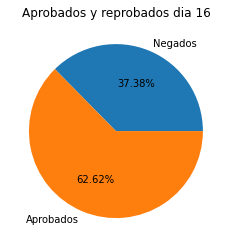

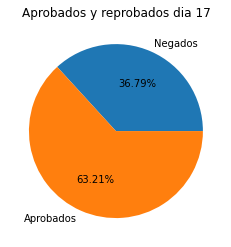

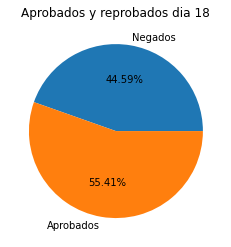

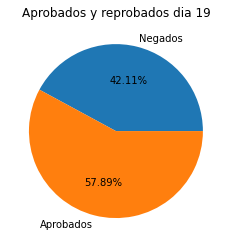

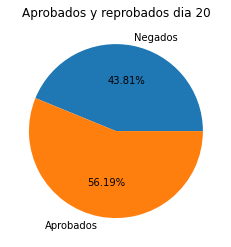

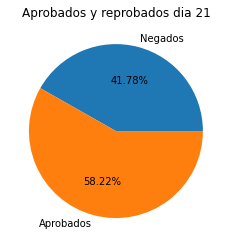

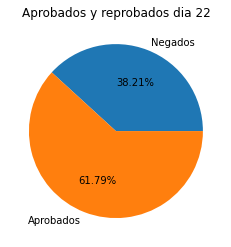

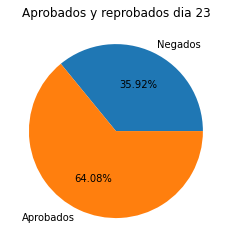

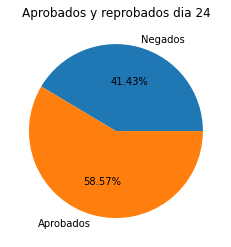

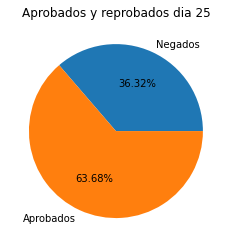

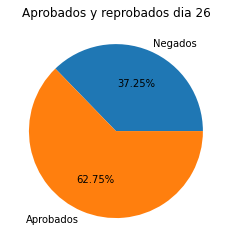

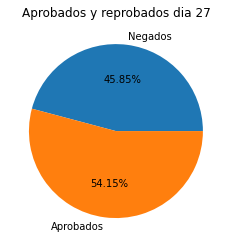

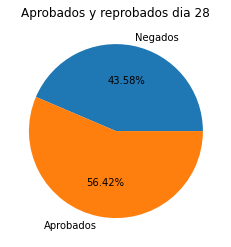

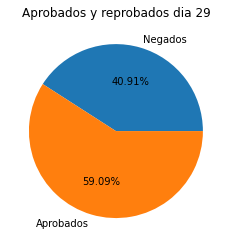

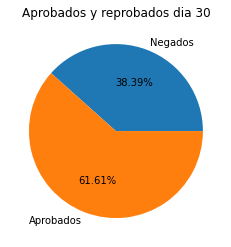

In [28]:
for x in prov_dia:

    numeros = [deneg_dia[x],prov_dia[x]]
    nombres = ["Negados","Aprobados"]
    titulo="Aprobados y reprobados dia "+str(x)
    plt.title(titulo)
    plt.pie(numeros, labels=nombres,autopct='%1.2f%%')
    plt.show()




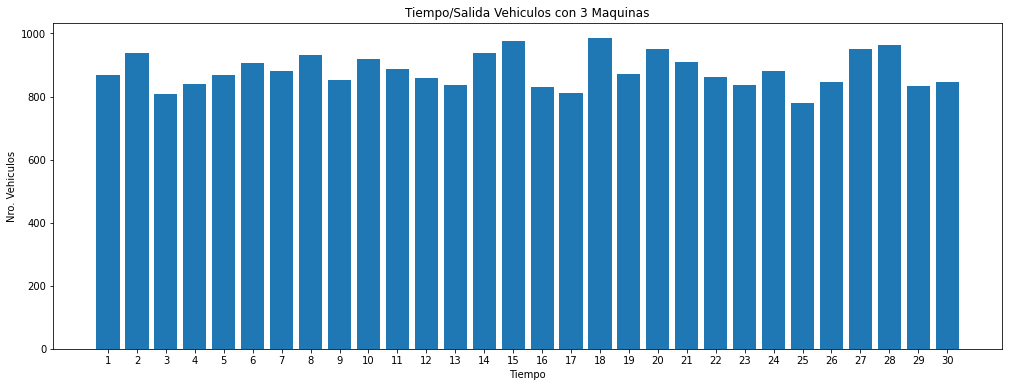

In [30]:


etiqueta = list(tiempos_dia.keys())
valores = list(tiempos_dia.values())
plt.figure(figsize=(17,6), )
plt.bar(range(len(tiempos_dia)), valores, align="center", tick_label=etiqueta)
plt.title("Tiempo total de atencion Vehiculos en total por dia")
plt.xlabel("Dia")
plt.ylabel("Tiempo en minutos")
plt.show()
